<a href="https://colab.research.google.com/github/happy-jihye/GAN/blob/main/2_CGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2 - Conditional Generative Adversarial Net(CGAN)

- [Conditional Generative Adversarial Net](https://arxiv.org/abs/1411.1784)

> - 2021/03/22 Happy-jihye
> - **Reference** : [eriklindernoren/PyTorch-GAN](https://github.com/eriklindernoren/PyTorch-GAN)

---


In [ ]:
import torch
import torch.nn as nn

import numpy as np

# for MNIST data
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.autograd import Variable


import matplotlib.pyplot as plt

## **Loading MNIST Data**

In [ ]:
# size of the batches
batch_size = 64

# number of epochs of training
n_epochs = 200 

# interval between image samples
sample_interval = 400

# dimensionality of the latent space
latent_dim = 100

# learning rate
lr = 0.0002

# decay of first order momentum of gradient
b1 = 0.5
b2 = 0.999

# number of image channels
channels = 1
# size of each image dimension
img_size = 32

img_shape = (channels, img_size, img_size)

# number of classes for dataset
n_classes = 10

In [ ]:
# download the MINST data

transforms_train = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(), # data를 pytorch의 tensor형식으로 바꿉니다
    transforms.Normalize([0.5], [0.5]) # 픽셀값을 0 ~ 1에서 -1 ~ 1 로 바꿔줍니다.
])

train_dataset = datasets.MNIST(root="./dataset", train=True, download=True, transform=transforms_train)

# data를 batch size만큼만 가져오는 dataloader를 만듭니다.
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True)

- 하나의 batch에 들어있는 mnist data를 출력해보았습니다.

[tensor(7), tensor(6), tensor(0), tensor(0), tensor(9), tensor(7), tensor(8), tensor(9), tensor(7), tensor(1), tensor(1), tensor(7), tensor(0), tensor(9), tensor(8), tensor(6), tensor(3), tensor(3), tensor(3), tensor(3), tensor(7), tensor(8), tensor(2), tensor(1), tensor(9), tensor(9), tensor(9), tensor(0), tensor(4), tensor(8), tensor(5), tensor(4), tensor(2), tensor(7), tensor(8), tensor(2), tensor(0), tensor(9), tensor(3), tensor(0), tensor(8), tensor(4), tensor(9), tensor(3), tensor(9), tensor(2), tensor(7), tensor(5), tensor(5), tensor(0), tensor(2), tensor(2), tensor(5), tensor(4), tensor(2), tensor(8), tensor(2), tensor(7), tensor(2), tensor(6), tensor(0), tensor(5), tensor(3), tensor(1)]


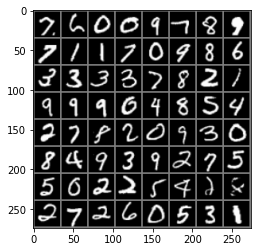

In [ ]:
images, labels = next(iter(dataloader))
img = torchvision.utils.make_grid(images)

img = img.numpy().transpose(1,2,0)
std = [0.5,0.5,0.5]
mean = [0.5,0.5,0.5]
img = img*std+mean
print([labels[i] for i in range(64)])
plt.imshow(img)

##  Generator

In [ ]:
# # dimensionality of the latent space
# # latent vector를 추출하기 위한 noise 분포의 dimension (정규분포를 따름)
# latent_dim = 100

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(n_classes, n_classes)
        
        def block(input_dim, output_dim, normalize=True):
            layers = [nn.Linear(input_dim, output_dim)]
            if normalize:
                layers.append(nn.BatchNorm1d(output_dim, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        # generater의 model은 여러개의 block을 쌓아서 만들어짐
        self.model = nn.Sequential(
            *block(latent_dim + n_classes, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh() 
        )

    def forward(self, noise, labels): 
      # Concatenate label embedding and image to produce input
      gan_input = torch.cat((self.label_emb(labels), noise), -1)  
      img = self.model(gan_input)
      img = img.view(img.size(0), *img_shape)
      return img

## Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.label_embedding = nn.Embedding(n_classes, n_classes)

        self.model = nn.Sequential(
            nn.Linear(n_classes + int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1)
        )

    # 이미지에 대한 판별 결과를 반환
    def forward(self, img, labels):
      # Concatenate label embedding and image to produce input
      d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
      validity = self.model(d_in)

      return validity

## Loss Function & Optimizer

- 손실 함수로는 Binary Cross Entropy를, 최적화 함수로는 Adam을 사용합니다.

In [ ]:
''' Hyper parameter '''
# # learning rate
# lr = 0.0002

# # decay of first order momentum of gradient
# b1 = 0.5
# b2 = 0.999


# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

# Loss function
adversarial_loss = nn.MSELoss()

# Adam Optimizer
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

In [ ]:
# GPU
cuda = True if torch.cuda.is_available() else False

if cuda : 
  generator.cuda()
  discriminator.cuda()
  adversarial_loss.cuda()

# Training

In [ ]:
import time

## number of epochs of training
# n_epochs = 200 

## interval between image samples
# sample_interval = 400

start_time = time.time()

from torch.autograd import Variable
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(dataloader):

        batch_size = imgs.shape[0]

        # Adversarial ground truths
        ## 실제 이미지는 1로, 가짜 이미지는 0으로 label됩니다. 
        real = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))))
        generated_labels = Variable(LongTensor(np.random.randint(0, n_classes, batch_size)))

        # Generate a batch of images
        ## random sampling한 값인 z를 생성자에 넣어 이미지를 생성합니다.
        generated_imgs = generator(z, generated_labels)

        # Loss measures generator's ability to fool the discriminator
        ## 생성된 이미지를 discriminator가 판별하게 한 후, loss값을 계산합니다.
        g_loss = adversarial_loss(discriminator(generated_imgs, generated_labels), real)

        # 생성자(generator) 업데이트
        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        ## 실제 이미지는 real(1)로, 가짜 이미지는 fake(0)으로 판별하도록 계산합니다.
        real_loss = adversarial_loss(discriminator(real_imgs, labels), real)
        fake_loss = adversarial_loss(discriminator(generated_imgs.detach(), generated_labels), fake)
        d_loss = (real_loss + fake_loss) / 2

        # 판별자(discriminator) 업데이트
        d_loss.backward()
        optimizer_D.step()
                
        done = epoch * len(dataloader) + i
        if done % sample_interval == 0:
            # 생성된 이미지 중에서 25개만 선택하여 5 X 5 격자 이미지에 출력
            save_image(generated_imgs.data[:25], f"data{epoch}.png", nrow=5, normalize=True)

    print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")

[Epoch 0/200] [D loss: 0.192096] [G loss: 0.350426] [Elapsed time: 14.59s]
[Epoch 1/200] [D loss: 0.169431] [G loss: 0.462645] [Elapsed time: 29.27s]
[Epoch 2/200] [D loss: 0.155148] [G loss: 0.486092] [Elapsed time: 43.90s]
[Epoch 3/200] [D loss: 0.220802] [G loss: 0.495513] [Elapsed time: 58.55s]
[Epoch 4/200] [D loss: 0.199521] [G loss: 0.396951] [Elapsed time: 73.32s]
[Epoch 5/200] [D loss: 0.246875] [G loss: 0.319541] [Elapsed time: 88.05s]
[Epoch 6/200] [D loss: 0.213544] [G loss: 0.251134] [Elapsed time: 102.83s]
[Epoch 7/200] [D loss: 0.182873] [G loss: 0.323939] [Elapsed time: 117.60s]
[Epoch 8/200] [D loss: 0.199896] [G loss: 0.415260] [Elapsed time: 132.55s]
[Epoch 9/200] [D loss: 0.244896] [G loss: 0.338733] [Elapsed time: 147.40s]
[Epoch 10/200] [D loss: 0.224951] [G loss: 0.388236] [Elapsed time: 162.14s]
[Epoch 11/200] [D loss: 0.193907] [G loss: 0.406296] [Elapsed time: 176.91s]
[Epoch 12/200] [D loss: 0.215571] [G loss: 0.333463] [Elapsed time: 191.76s]
[Epoch 13/200] 

## Image

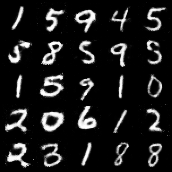

In [ ]:
from IPython.display import Image

Image('106000.png')

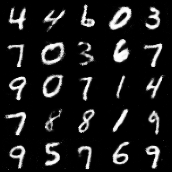

In [ ]:
Image('100000.png')

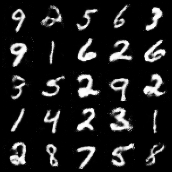

In [ ]:
Image('100400.png')